In [45]:
# default_exp data/syntheticData

In [5]:
# export
import numpy as np

In [6]:
import scipy.stats as ss
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'num positive pmf')

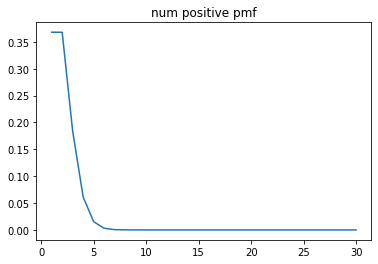

In [19]:
plt.plot(np.arange(1,31,1),ss.poisson.pmf(np.arange(0,30,1),1))
plt.title("num positive pmf")

Text(0.5, 1.0, 'num unlabeled pmf')

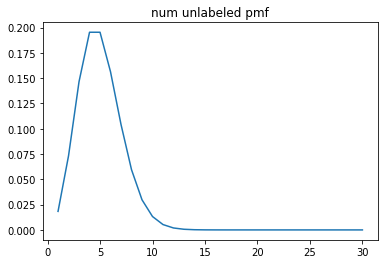

In [ ]:
plt.plot(np.arange(1,31,1), ss.poisson.pmf(np.arange(0,30,1),4))
plt.title("num unlabeled pmf")

Text(0.5, 1.0, 'alpha pdf')

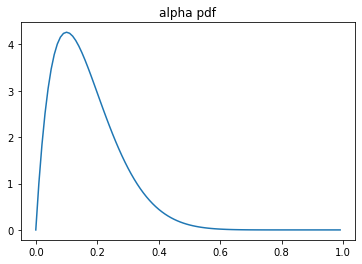

In [14]:
plt.plot(np.arange(0,1,.01),ss.beta.pdf(np.arange(0,1,.01),2,10))
plt.title("alpha pdf")

In [54]:
# export

def getBag(nP=None, nU=None,posMean=None, negMean=None,cov=None,
           alphaDistr=lambda: np.random.beta(2,10)):
    if nP is None:
        nP = np.random.poisson(1) + 1
    if nU is None:
        nU = np.random.poisson(4) + 1
    alpha = alphaDistr()
    numUnlabeledPos = int(alpha * nU)
    numUnlabeledNeg = nU - numUnlabeledPos
    # Sample Positive Points
    oneD = type(posMean) in [int, float]
    if oneD:
        ptsPos = np.random.normal(posMean,cov,size=nP)
        ptsUnlabeled = np.concatenate([
                np.random.normal(posMean,
                                 cov,
                                 size=numUnlabeledPos),
                np.random.normal(negMean,
                                 cov,
                                 size=numUnlabeledNeg)
            ],axis=0)
    else:
        ptsPos = np.random.multivariate_normal(posMean, cov,size=nP)
        ptsUnlabeled = np.concatenate([
                np.random.multivariate_normal(posMean,
                                              cov,
                                              size=numUnlabeledPos),
                np.random.multivariate_normal(negMean,
                                              cov,
                                              size=numUnlabeledNeg)
            ],axis=0)
    hiddenLabels = np.concatenate((np.ones(numUnlabeledPos),
                                   np.zeros(numUnlabeledNeg)))
    return {"positiveInstances":ptsPos,
            "unlabeledInstances": ptsUnlabeled,
            "alpha_i":alpha,
           "hiddenLabels": hiddenLabels,
           "posMean": posMean,
           "negMean": negMean,
           "cov": cov}, ptsPos.shape[0], ptsUnlabeled.shape[0]

In [57]:
# export
def buildDatasetDict(size,nP=None,nU=None,posMean=None, negMean=None,cov=None,
                     alphaDistr=lambda: np.random.beta(2,10),):
    if posMean is None:
        dim = np.random.poisson(1) + 1
        posMean = np.random.normal(loc=0,scale=3,size=dim)
        negMean = np.random.normal(loc=0,scale=3,size=dim)
        cov = np.eye(dim)
    bags, numPs, numUs = list(zip(*[getBag(nP=nP,nU=nU,posMean=posMean,negMean=negMean,cov=cov,alphaDistr=alphaDistr) for _ in range(size)]))
    maxP, maxU = np.max(numPs), np.max(numUs)
    d = bags[0]["positiveInstances"].shape[1]
    posMats = np.zeros((len(bags), maxP, d))
    unlabeledMats = np.zeros((len(bags), maxU, d))
    hiddenLabelMats = np.zeros((len(bags), maxU))
    alphas = np.zeros((len(bags), 1))
    numPos = np.zeros(len(bags),dtype=int)
    numU = np.zeros(len(bags),dtype=int)
    for bagNum,bag in enumerate(bags):
        posPadding = maxP - bag["positiveInstances"].shape[0]
        unlabeledPadding = maxU - bag["unlabeledInstances"].shape[0]
        dim = bag["positiveInstances"].shape[1]
        p_mat= np.concatenate((bag["positiveInstances"], np.zeros((posPadding, d))), axis=0)
        posMats[bagNum] = p_mat
        u_mat= np.concatenate((bag["unlabeledInstances"], np.zeros((unlabeledPadding, d))), axis=0)
        unlabeledMats[bagNum] = u_mat
        hiddenLabelMats[bagNum] = np.concatenate((bag["hiddenLabels"], np.zeros(unlabeledPadding)))
        alphas[bagNum] = bag["alpha_i"]
        numPos[bagNum] = bag["positiveInstances"].shape[0]
        numU[bagNum] = bag["unlabeledInstances"].shape[0]
    
    return {
        "positiveInstances": posMats,
        "unlabeledInstances": unlabeledMats,
        "alpha_i": alphas,
        "numP": numPos,
        "numU": numU,
        "hiddenLabels": hiddenLabelMats,
        "posMean": posMean,
        "negMean": negMean,
        "cov": cov
    }

In [58]:
# export
class Dataset:
    def __init__(self, d):
        self.positiveInstances = d["positiveInstances"]
        self.unlabeledInstances = d["unlabeledInstances"]
        self.trueAlphas = d["alpha_i"]
        self.N = self.positiveInstances.shape[0]
        self.numP = d["numP"]
        self.numU = d["numU"]
        self.hiddenLabels = d["hiddenLabels"]
        self.posDistMean = d["posMean"]
        self.negDistMean = d["negMean"]
        self.cov = d["cov"]
        
    def getBag(self,idx):
        p = self.positiveInstances[idx, :self.numP[idx]]
        u = self.unlabeledInstances[idx, :self.numU[idx]]
        return p,u

In [61]:
# export
def buildDataset(size,nP=None,nU=None,posMean=None, negMean=None,cov=None,alphaDistr=lambda: np.random.beta(2,10)):
    ddict = buildDatasetDict(size,nP=nP, nU=nU, posMean=posMean, negMean=negMean, cov=cov, alphaDistr=alphaDistr)
    return Dataset(ddict)

In [62]:
# hide
d = buildDataset(10, alphaDistr=lambda: np.random.beta(2,2))